In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb

# 1. Cargar y agregar por producto y mes
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# 2. Crear features
def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month
    for lag in range(1, 4):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)
    return data

df_feat = crear_features(df)

# 3. Leer universo de productos
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()

# 4. Inicializar
resultados = []
entrenados = 0
fallbacks = 0

# 5. Loop por producto
for producto in productos_objetivo:
    data_prod = df_feat[df_feat["product_id"] == producto].copy()
    train = data_prod[data_prod["periodo"] <= "2019-12-01"]
    train = train.dropna(subset=["lag_1", "lag_2", "lag_3"])

    try:
        if train.shape[0] >= 2:
            X_train = train[["month", "lag_1", "lag_2", "lag_3"]]
            y_train = train["tn"]

            dtrain = lgb.Dataset(X_train, label=y_train)

            params = {
                "objective": "regression",
                "metric": "mae",
                "verbosity": -1,
                "boosting_type": "gbdt",
                "learning_rate": 0.1,
                "max_depth": 5,
                "num_leaves": 15,
                "min_data_in_leaf": 10,
                "feature_fraction": 0.7,
                "bagging_fraction": 0.7,
                "bagging_freq": 1,
                "seed": 42
            }

            model = lgb.train(params, dtrain, num_boost_round=100, verbose_eval=False)

            dic = data_prod.loc[data_prod["periodo"] == "2019-12-01", "tn"]
            nov = data_prod.loc[data_prod["periodo"] == "2019-11-01", "tn"]
            octu = data_prod.loc[data_prod["periodo"] == "2019-10-01", "tn"]

            if not dic.empty and not nov.empty and not octu.empty:
                X_pred = pd.DataFrame([[2, dic.values[0], nov.values[0], octu.values[0]]],
                                      columns=["month", "lag_1", "lag_2", "lag_3"])
                pred = model.predict(X_pred)[0]
                resultados.append({"product_id": producto, "tn_predicho": pred})
                entrenados += 1
                continue

    except Exception as e:
        print(f"⚠️ Fallo producto {producto}: {e}")

    # Fallback combinado
    data_hist = df[(df["product_id"] == producto) & (df["periodo"] < "2020-01-01")].copy()
    ultimos_12 = data_hist.sort_values("periodo").tail(12)
    prom_ultimos12 = ultimos_12["tn"].mean() if not ultimos_12.empty else 0.0
    febreros = data_hist[data_hist["periodo"].dt.month == 2]
    prom_febreros = febreros["tn"].mean() if not febreros.empty else 0.0
    pred = 0.6 * prom_ultimos12 + 0.4 * prom_febreros

    resultados.append({"product_id": producto, "tn_predicho": pred})
    fallbacks += 1

# 6. Exportar
df_resultado = pd.DataFrame(resultados)
df_resultado.to_csv("predicciones_febrero2020_lgbm_780_combinado_AGREGADO.csv", index=False)

print("✅ Archivo generado: predicciones_febrero2020_lgbm_780_combinado_AGREGADO.csv")
print(f"🟢 Modelos entrenados: {entrenados}")
print(f"🟡 Fallbacks aplicados: {fallbacks}")
print(f"🔢 Total productos: {len(df_resultado)}")


c:\Users\waldo\miniconda3\envs\predprod1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\waldo\miniconda3\envs\predprod1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\waldo\miniconda3\envs\predprod1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

✅ Archivo generado: predicciones_febrero2020_lgbm_780_combinado_AGREGADO.csv
🟢 Modelos entrenados: 771
🟡 Fallbacks aplicados: 9
🔢 Total productos: 780


c:\Users\waldo\miniconda3\envs\predprod1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\waldo\miniconda3\envs\predprod1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\waldo\miniconda3\envs\predprod1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

In [7]:
df[df["product_id"] == 20001].sort_values("periodo").tail(6)


,product_id,periodo,tn
30,20001,2019-07-01,1678.99318
31,20001,2019-08-01,1261.34529
32,20001,2019-09-01,1660.00561
33,20001,2019-10-01,1561.50552
34,20001,2019-11-01,1397.37231
35,20001,2019-12-01,1504.68856


In [8]:
serie = df[df["product_id"] == 20001].set_index("periodo")["tn"].resample("MS").sum()
print(serie.tail(12))


periodo
2019-01-01    1275.77351
2019-02-01    1259.09363
2019-03-01    1470.65653
2019-04-01    1647.63848
2019-05-01    1629.78233
2019-06-01    1109.93769
2019-07-01    1678.99318
2019-08-01    1261.34529
2019-09-01    1660.00561
2019-10-01    1561.50552
2019-11-01    1397.37231
2019-12-01    1504.68856
Freq: MS, Name: tn, dtype: float64


In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb

# 1. Cargar y agregar por producto y mes
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# 2. Crear features
def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month
    for lag in range(1, 13):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)
    # Deltas simples
    data["delta_1"] = data["lag_1"] - data["lag_2"]
    data["delta_2"] = data["lag_2"] - data["lag_3"]
    data["delta_3"] = data["lag_3"] - data["lag_4"]
    return data

df_feat = crear_features(df)

# 3. Leer universo de productos
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()

# 4. Inicializar
resultados = []
entrenados = 0
fallbacks = 0

# 5. Loop por producto
for producto in productos_objetivo:
    data_prod = df_feat[df_feat["product_id"] == producto].copy()
    train = data_prod[data_prod["periodo"] <= "2019-12-01"]
    train = train.dropna(subset=[f"lag_{i}" for i in range(1, 13)] + ["delta_1", "delta_2", "delta_3"])

    try:
        if train.shape[0] >= 5:
            features = ["month"] + [f"lag_{i}" for i in range(1, 13)] + ["delta_1", "delta_2", "delta_3"]
            X_train = train[features]
            y_train = train["tn"]

            dtrain = lgb.Dataset(X_train, label=y_train)

            params = {
                "objective": "regression",
                "metric": "mae",
                "verbosity": -1,
                "boosting_type": "gbdt",
                "learning_rate": 0.1,
                "max_depth": 5,
                "num_leaves": 15,
                "min_data_in_leaf": 10,
                "feature_fraction": 0.7,
                "bagging_fraction": 0.7,
                "bagging_freq": 1,
                "seed": 42
            }

            model = lgb.train(params, dtrain, num_boost_round=100, verbose_eval=False)

            fila_pred = data_prod.loc[data_prod["periodo"] == "2019-12-01"]
            if not fila_pred.empty and not fila_pred[features].isnull().any(axis=1).all():
                X_pred = fila_pred[features].iloc[0:1]
                pred = model.predict(X_pred)[0]
                resultados.append({"product_id": producto, "tn_predicho": pred})
                entrenados += 1
                continue

    except Exception as e:
        print(f"⚠️ Fallo producto {producto}: {e}")

    # Fallback combinado
    data_hist = df[(df["product_id"] == producto) & (df["periodo"] < "2020-01-01")].copy()
    ultimos_12 = data_hist.sort_values("periodo").tail(12)
    prom_ultimos12 = ultimos_12["tn"].mean() if not ultimos_12.empty else 0.0
    febreros = data_hist[data_hist["periodo"].dt.month == 2]
    prom_febreros = febreros["tn"].mean() if not febreros.empty else 0.0
    pred = 0.6 * prom_ultimos12 + 0.4 * prom_febreros

    resultados.append({"product_id": producto, "tn_predicho": pred})
    fallbacks += 1

# 6. Exportar
df_resultado = pd.DataFrame(resultados)
df_resultado.to_csv("predicciones_febrero2020_lgbm_lags12_deltas_combinado.csv", index=False)

print("✅ Archivo generado: predicciones_febrero2020_lgbm_lags12_deltas_combinado.csv")
print(f"🟢 Modelos entrenados: {entrenados}")
print(f"🟡 Fallbacks aplicados: {fallbacks}")
print(f"🔢 Total productos: {len(df_resultado)}")


c:\Users\waldo\miniconda3\envs\predprod1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\waldo\miniconda3\envs\predprod1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\waldo\miniconda3\envs\predprod1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

✅ Archivo generado: predicciones_febrero2020_lgbm_lags12_deltas_combinado.csv
🟢 Modelos entrenados: 608
🟡 Fallbacks aplicados: 172
🔢 Total productos: 780


c:\Users\waldo\miniconda3\envs\predprod1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar y agregar
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# 2. Reemplazar agosto por promedio últimos 12 meses
def reemplazar_agosto(grupo):
    grupo = grupo.copy()
    for i in range(len(grupo)):
        if grupo.iloc[i]["periodo"].month == 8 and i >= 12:
            grupo.iloc[i, grupo.columns.get_loc("tn")] = grupo.iloc[i-12:i]["tn"].mean()
    return grupo

df_corr = df.groupby("product_id").apply(reemplazar_agosto).reset_index(drop=True)

# 3. Crear features
def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month
    for lag in range(1, 13):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)
    data["delta_1"] = data["lag_1"] - data["lag_2"]
    data["delta_2"] = data["lag_2"] - data["lag_3"]
    data["delta_3"] = data["lag_3"] - data["lag_4"]
    return data

df_feat = crear_features(df_corr)

# 4. Leer universo
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()

# 5. Inicializar
resultados = []
entrenados = 0
fallbacks = 0

# 6. Loop por producto
for producto in productos_objetivo:
    data_prod = df_feat[df_feat["product_id"] == producto].copy()
    train = data_prod[data_prod["periodo"] <= "2019-12-01"]
    train = train.dropna(subset=[f"lag_{i}" for i in range(1, 13)] + ["delta_1", "delta_2", "delta_3"])

    try:
        if train.shape[0] >= 15:
            features = ["month"] + [f"lag_{i}" for i in range(1, 13)] + ["delta_1", "delta_2", "delta_3"]
            X = train[features]
            y = train["tn"]

            maes = []
            for train_idx, val_idx in KFold(n_splits=5, shuffle=False).split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                dtrain = lgb.Dataset(X_train, label=y_train)
                model = lgb.train(
                    {
                        "objective": "regression",
                        "metric": "mae",
                        "verbosity": -1,
                        "learning_rate": 0.1,
                        "num_leaves": 31,
                        "seed": 42
                    },
                    dtrain,
                    num_boost_round=100
                )

                y_pred_val = model.predict(X_val)
                maes.append(mean_absolute_error(y_val, y_pred_val))

            # Entrenar final
            model = lgb.LGBMRegressor(
                objective="regression",
                learning_rate=0.1,
                num_leaves=31,
                random_state=42
            )
            model.fit(X, y)

            fila_pred = data_prod.loc[data_prod["periodo"] == "2019-12-01"]
            if not fila_pred.empty and not fila_pred[features].isnull().any(axis=1).all():
                X_pred = fila_pred[features].iloc[0:1]
                pred = model.predict(X_pred)[0]
                resultados.append({"product_id": producto, "tn_predicho": pred})
                entrenados += 1
                continue

    except Exception as e:
        print(f"⚠️ Fallo producto {producto}: {e}")

    # Fallback
    data_hist = df[(df["product_id"] == producto) & (df["periodo"] < "2020-01-01")]
    ultimos_12 = data_hist.sort_values("periodo").tail(12)
    prom_ultimos12 = ultimos_12["tn"].mean() if not ultimos_12.empty else 0.0
    febreros = data_hist[data_hist["periodo"].dt.month == 2]
    prom_febreros = febreros["tn"].mean() if not febreros.empty else 0.0
    pred = 0.6 * prom_ultimos12 + 0.4 * prom_febreros

    resultados.append({"product_id": producto, "tn_predicho": pred})
    fallbacks += 1

# 7. Exportar
df_resultado = pd.DataFrame(resultados)
df_resultado.to_csv("predicciones_febrero2020_lgbm_agosto_cv.csv", index=False)

print("✅ Archivo generado: predicciones_febrero2020_lgbm_agosto_cv.csv")
print(f"🟢 Modelos entrenados con CV: {entrenados}")
print(f"🟡 Fallbacks aplicados: {fallbacks}")
print(f"🔢 Total productos: {len(df_resultado)}")


✅ Archivo generado: predicciones_febrero2020_lgbm_agosto_cv.csv
🟢 Modelos entrenados con CV: 549
🟡 Fallbacks aplicados: 231
🔢 Total productos: 780


In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar y agregar
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# 2. Reemplazo de agosto
def reemplazar_agosto(grupo):
    grupo = grupo.copy()
    for i in range(len(grupo)):
        if grupo.iloc[i]["periodo"].month == 8 and i >= 12:
            grupo.iloc[i, grupo.columns.get_loc("tn")] = grupo.iloc[i-12:i]["tn"].mean()
    return grupo

df_corr = df.groupby("product_id").apply(reemplazar_agosto).reset_index(drop=True)

# 3. Features
def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month
    for lag in range(1, 13):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)
    data["delta_1"] = data["lag_1"] - data["lag_2"]
    data["delta_2"] = data["lag_2"] - data["lag_3"]
    data["delta_3"] = data["lag_3"] - data["lag_4"]
    return data

df_feat = crear_features(df_corr)

# 4. Leer universo
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()

# 5. Inicializar
resultados = []
maes_lgbm = []
entrenados = 0
fallbacks = 0

# 6. Loop por producto
for producto in productos_objetivo:
    data_prod = df_feat[df_feat["product_id"] == producto].copy()
    train = data_prod[data_prod["periodo"] <= "2019-12-01"]
    train = train.dropna(subset=[f"lag_{i}" for i in range(1, 13)] + ["delta_1", "delta_2", "delta_3"])

    try:
        if train.shape[0] >= 15:
            features = ["month"] + [f"lag_{i}" for i in range(1, 13)] + ["delta_1", "delta_2", "delta_3"]
            X = train[features]
            y = train["tn"]

            maes = []
            for train_idx, val_idx in KFold(n_splits=5, shuffle=False).split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                modelo = lgb.LGBMRegressor(
                    learning_rate=0.1,
                    n_estimators=100,
                    max_depth=6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42
                )
                modelo.fit(X_train, y_train)
                y_pred_val = modelo.predict(X_val)
                maes.append(mean_absolute_error(y_val, y_pred_val))

            mae_cv = np.mean(maes)
            modelo.fit(X, y)

            fila_pred = data_prod.loc[data_prod["periodo"] == "2019-12-01"]
            if not fila_pred.empty and not fila_pred[features].isnull().any(axis=1).all():
                X_pred = fila_pred[features].iloc[0:1]
                pred = modelo.predict(X_pred)[0]
                resultados.append({"product_id": producto, "tn_predicho": pred})
                maes_lgbm.append({"product_id": producto, "mae_cv": mae_cv})
                entrenados += 1
                continue

    except Exception as e:
        print(f"\u26a0\ufe0f Fallo producto {producto}: {e}")

    # Fallback
    data_hist = df[(df["product_id"] == producto) & (df["periodo"] < "2020-01-01")]
    ultimos_12 = data_hist.sort_values("periodo").tail(12)
    prom_ultimos12 = ultimos_12["tn"].mean() if not ultimos_12.empty else 0.0
    febreros = data_hist[data_hist["periodo"].dt.month == 2]
    prom_febreros = febreros["tn"].mean() if not febreros.empty else 0.0
    pred = 0.6 * prom_ultimos12 + 0.4 * prom_febreros

    resultados.append({"product_id": producto, "tn_predicho": pred})
    maes_lgbm.append({"product_id": producto, "mae_cv": 9999})  # Fallback → MAE muy alto
    fallbacks += 1

# 7. Exportar
pd.DataFrame(resultados).to_csv("predicciones_febrero2020_lgbm_agosto_cv1.csv", index=False)
pd.DataFrame(maes_lgbm).to_csv("mae_lgbm_cv1.csv", index=False)

print("\ Archivo generado: predicciones_febrero2020_lgbm_agosto_cv1.csv")
print("\ MAE por producto: mae_lgbm_cv1.csv")
print(f"\ Modelos entrenados: {entrenados}")
print(f"\ Fallbacks aplicados: {fallbacks}")
print(f"\ Total productos: {len(productos_objetivo)}")


\ Archivo generado: predicciones_febrero2020_lgbm_agosto_cv1.csv
\ MAE por producto: mae_lgbm_cv1.csv
\ Modelos entrenados: 549
\ Fallbacks aplicados: 231
\ Total productos: 780


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar y agregar
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# 2. Reemplazo de agosto
def reemplazar_agosto(grupo):
    grupo = grupo.copy()
    for i in range(len(grupo)):
        if grupo.iloc[i]["periodo"].month == 8 and i >= 12:
            grupo.iloc[i, grupo.columns.get_loc("tn")] = grupo.iloc[i-12:i]["tn"].mean()
    return grupo

df_corr = df.groupby("product_id").apply(reemplazar_agosto).reset_index(drop=True)

# 3. Features
def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month
    for lag in range(1, 13):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)
    data["delta_1"] = data["lag_1"] - data["lag_2"]
    data["delta_2"] = data["lag_2"] - data["lag_3"]
    data["delta_3"] = data["lag_3"] - data["lag_4"]
    return data

df_feat = crear_features(df_corr)

# 4. Leer universo
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()

# 5. Inicializar
resultados = []
maes_lgbm = []
predicciones_validacion = []
entrenados = 0
fallbacks = 0

# 6. Loop por producto
for producto in productos_objetivo:
    data_prod = df_feat[df_feat["product_id"] == producto].copy()
    train = data_prod[data_prod["periodo"] <= "2019-12-01"]
    train = train.dropna(subset=[f"lag_{i}" for i in range(1, 13)] + ["delta_1", "delta_2", "delta_3"])

    try:
        if train.shape[0] >= 15:
            features = ["month"] + [f"lag_{i}" for i in range(1, 13)] + ["delta_1", "delta_2", "delta_3"]
            X = train[features]
            y = train["tn"]

            maes = []
            for train_idx, val_idx in KFold(n_splits=5, shuffle=False).split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                modelo = lgb.LGBMRegressor(
                    learning_rate=0.1,
                    n_estimators=100,
                    max_depth=6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42
                )
                modelo.fit(X_train, y_train)
                y_pred_val = modelo.predict(X_val)
                maes.append(mean_absolute_error(y_val, y_pred_val))

                df_val = pd.DataFrame({
                    "product_id": producto,
                    "real": y_val.values,
                    "pred": y_pred_val,
                    "abs_error": np.abs(y_val.values - y_pred_val)
                })
                predicciones_validacion.append(df_val)

            mae_cv = np.mean(maes)
            modelo.fit(X, y)

            fila_pred = data_prod.loc[data_prod["periodo"] == "2019-12-01"]
            if not fila_pred.empty and not fila_pred[features].isnull().any(axis=1).all():
                X_pred = fila_pred[features].iloc[0:1]
                pred = modelo.predict(X_pred)[0]
                resultados.append({"product_id": producto, "tn_predicho": pred})
                maes_lgbm.append({"product_id": producto, "mae_cv": mae_cv})
                entrenados += 1
                continue

    except Exception as e:
        print(f"\u26a0\ufe0f Fallo producto {producto}: {e}")

    # Fallback
    data_hist = df[(df["product_id"] == producto) & (df["periodo"] < "2020-01-01")]
    ultimos_12 = data_hist.sort_values("periodo").tail(12)
    prom_ultimos12 = ultimos_12["tn"].mean() if not ultimos_12.empty else 0.0
    febreros = data_hist[data_hist["periodo"].dt.month == 2]
    prom_febreros = febreros["tn"].mean() if not febreros.empty else 0.0
    pred = 0.6 * prom_ultimos12 + 0.4 * prom_febreros

    resultados.append({"product_id": producto, "tn_predicho": pred})
    maes_lgbm.append({"product_id": producto, "mae_cv": 9999})
    fallbacks += 1

# 7. Exportar
pd.DataFrame(resultados).to_csv("predicciones_febrero2020_lgbm_agosto_cv1.csv", index=False)
pd.DataFrame(maes_lgbm).to_csv("mae_lgbm_cv1.csv", index=False)
val_real_pred = pd.concat(predicciones_validacion, ignore_index=True)
val_real_pred.to_csv("val_real_vs_pred_lgbm_cv1.csv", index=False)

print("\nArchivo generado: predicciones_febrero2020_lgbm_agosto_cv1.csv")
print("MAE por producto: mae_lgbm_cv1.csv")
print("Validación real vs. predicción: val_real_vs_pred_lgbm_cv1.csv")
print(f"Modelos entrenados: {entrenados}")
print(f"Fallbacks aplicados: {fallbacks}")
print(f"Total productos: {len(productos_objetivo)}")



Archivo generado: predicciones_febrero2020_lgbm_agosto_cv1.csv
MAE por producto: mae_lgbm_cv1.csv
Validación real vs. predicción: val_real_vs_pred_lgbm_cv1.csv
Modelos entrenados: 549
Fallbacks aplicados: 231
Total productos: 780


In [3]:
import pandas as pd

# Cargar archivo con valores reales y predichos
df = pd.read_csv("val_real_vs_pred_lgbm_cv1.csv")

# Agrupar por product_id y calcular MAE
df["error_abs"] = abs(df["real"] - df["pred"])
mae_por_producto = df.groupby("product_id")["error_abs"].mean().reset_index()
mae_por_producto = mae_por_producto.sort_values("error_abs", ascending=False)

# Mostrar los 15 con mayor MAE
top_15 = mae_por_producto.head(15)
print(top_15)


    product_id   error_abs
0        20001  213.399215
1        20002  205.351584
4        20005  176.019929
2        20003  164.421682
6        20007  163.894314
3        20004  137.432757
11       20012  134.363671
5        20006  120.805899
15       20016  113.192016
8        20009  111.086294
9        20010  105.199991
7        20008   99.487279
29       20030   94.893653
21       20022   93.899899
10       20011   92.612540


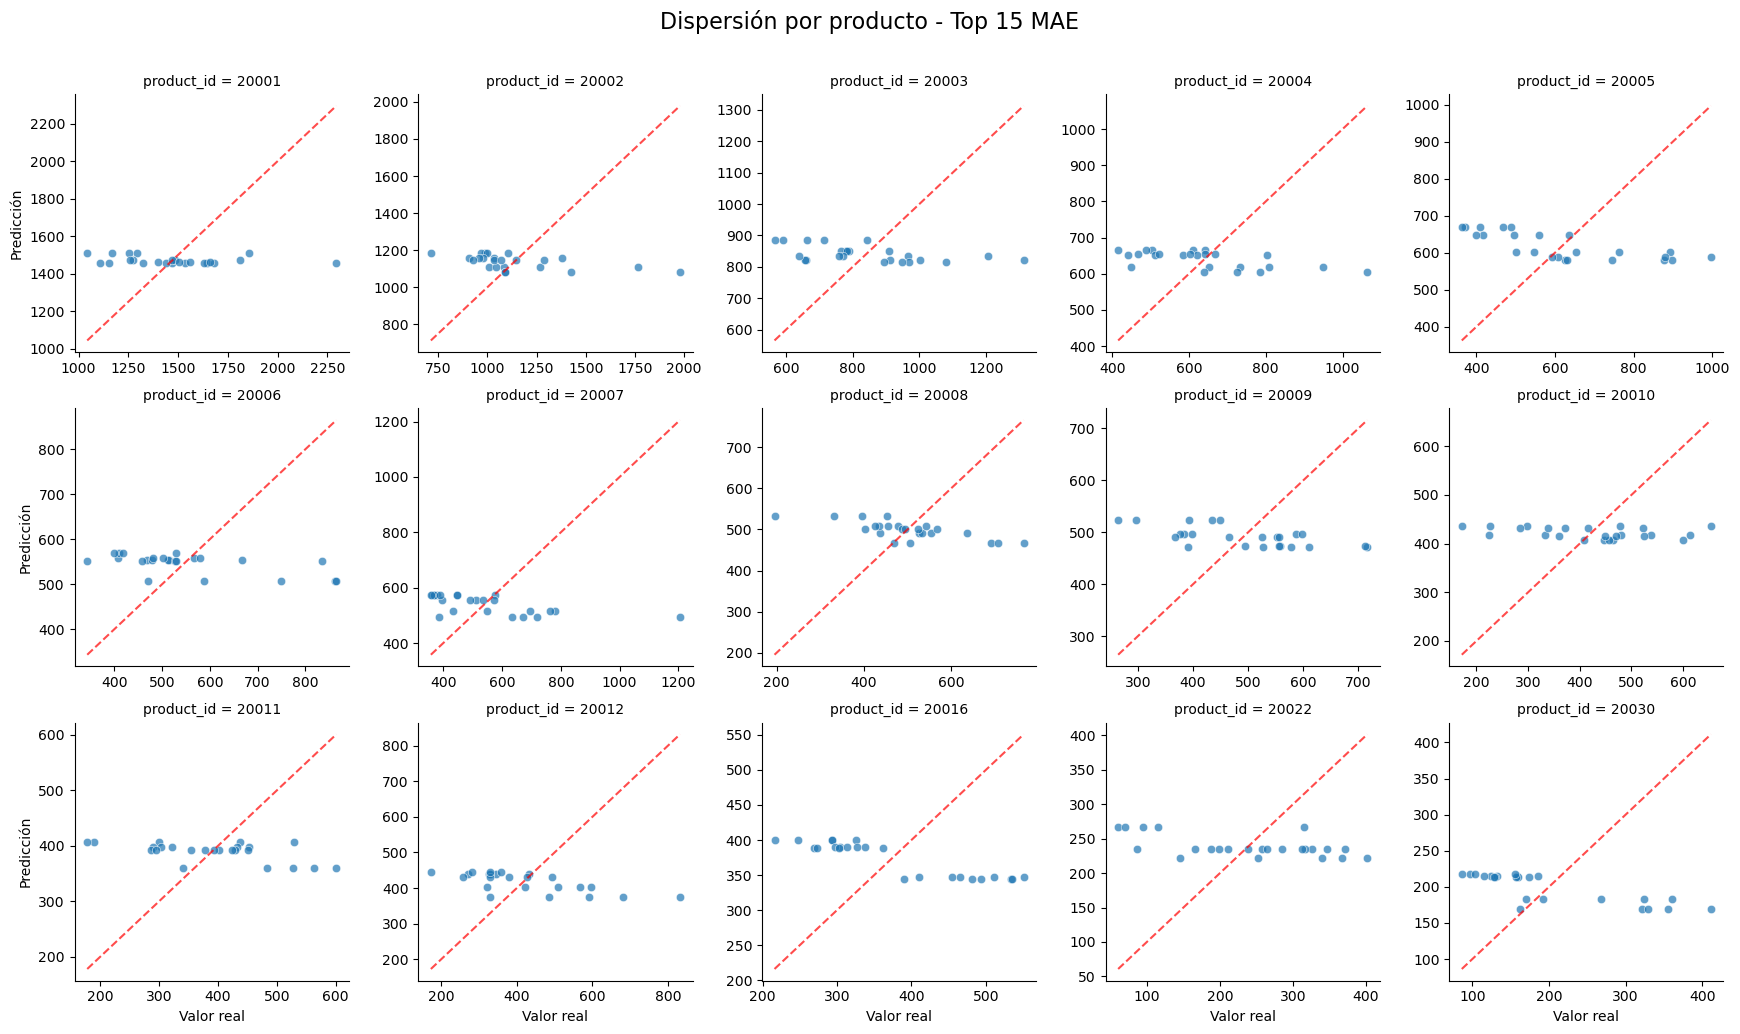

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Cargar archivo generado
df = pd.read_csv("val_real_vs_pred_lgbm_cv1.csv")

# Calcular MAE por producto
df["abs_error"] = abs(df["real"] - df["pred"])
top_mae = df.groupby("product_id")["abs_error"].mean().sort_values(ascending=False).head(15).index
df_top15 = df[df["product_id"].isin(top_mae)]

# Función para agregar línea de identidad
def identidad(data, **kwargs):
    ax = plt.gca()
    lims = [
        min(data["real"].min(), data["pred"].min()),
        max(data["real"].max(), data["pred"].max())
    ]
    ax.plot(lims, lims, 'r--', alpha=0.7)

# Plot
g = sns.FacetGrid(df_top15, col="product_id", col_wrap=5, height=3.5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="real", y="pred", alpha=0.7)
g.map_dataframe(identidad)
g.set_axis_labels("Valor real", "Predicción")
g.fig.suptitle("Dispersión por producto - Top 15 MAE", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show(  )    
plt.savefig("top15_dispersión_lgbm_cv1.png")
plt.close()


In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar y agregar
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# 2. Reemplazo de agosto
def reemplazar_agosto(grupo):
    grupo = grupo.copy()
    for i in range(len(grupo)):
        if grupo.iloc[i]["periodo"].month == 8 and i >= 12:
            grupo.iloc[i, grupo.columns.get_loc("tn")] = grupo.iloc[i-12:i]["tn"].mean()
    return grupo

df_corr = df.groupby("product_id").apply(reemplazar_agosto).reset_index(drop=True)

# 3. Features

def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month

    for lag in range(1, 13):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)

    # Deltas
    data["delta_1"] = data["lag_1"] - data["lag_2"]
    data["delta_2"] = data["lag_2"] - data["lag_3"]
    data["delta_3"] = data["lag_3"] - data["lag_4"]

    # Rolling mean y std
    data["rolling_mean_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).mean())
    data["rolling_std_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).std())
    data["rolling_mean_6"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).mean())
    data["rolling_std_6"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).std())

    # Interacciones
    data["lag_1*lag_2"] = data["lag_1"] * data["lag_2"]
    data["lag_1*delta_1"] = data["lag_1"] * data["delta_1"]
    data["lag_1/lag_2"] = data["lag_1"] / (data["lag_2"] + 1e-6)

    return data

df_feat = crear_features(df_corr)

# 4. Leer universo
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()

# 5. Inicializar
resultados = []
maes_lgbm = []
entrenados = 0
fallbacks = 0

# 6. Loop por producto
for producto in productos_objetivo:
    data_prod = df_feat[df_feat["product_id"] == producto].copy()
    train = data_prod[data_prod["periodo"] <= "2019-12-01"]

    columnas_lags = [f"lag_{i}" for i in range(1, 13)]
    columnas_adicionales = ["delta_1", "delta_2", "delta_3", "rolling_mean_3", "rolling_std_3",
                            "rolling_mean_6", "rolling_std_6", "lag_1*lag_2", "lag_1*delta_1", "lag_1/lag_2"]

    columnas_features = ["month"] + columnas_lags + columnas_adicionales

    train = train.dropna(subset=columnas_features)

    try:
        if train.shape[0] >= 15:
            X = train[columnas_features]
            y = train["tn"]

            maes = []
            for train_idx, val_idx in KFold(n_splits=5, shuffle=False).split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                modelo = lgb.LGBMRegressor(
                    learning_rate=0.1,
                    n_estimators=100,
                    max_depth=6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42
                )
                modelo.fit(X_train, y_train)
                y_pred_val = modelo.predict(X_val)
                maes.append(mean_absolute_error(y_val, y_pred_val))

            mae_cv = np.mean(maes)
            modelo.fit(X, y)

            fila_pred = data_prod.loc[data_prod["periodo"] == "2019-12-01"]
            if not fila_pred.empty and not fila_pred[columnas_features].isnull().any(axis=1).all():
                X_pred = fila_pred[columnas_features].iloc[0:1]
                pred = modelo.predict(X_pred)[0]
                resultados.append({"product_id": producto, "tn_predicho": pred})
                maes_lgbm.append({"product_id": producto, "mae_cv": mae_cv})
                entrenados += 1
                continue

    except Exception as e:
        print(f"\u26a0\ufe0f Fallo producto {producto}: {e}")

    # Fallback
    data_hist = df[(df["product_id"] == producto) & (df["periodo"] < "2020-01-01")]
    ultimos_12 = data_hist.sort_values("periodo").tail(12)
    prom_ultimos12 = ultimos_12["tn"].mean() if not ultimos_12.empty else 0.0
    febreros = data_hist[data_hist["periodo"].dt.month == 2]
    prom_febreros = febreros["tn"].mean() if not febreros.empty else 0.0
    pred = 0.6 * prom_ultimos12 + 0.4 * prom_febreros

    resultados.append({"product_id": producto, "tn_predicho": pred})
    maes_lgbm.append({"product_id": producto, "mae_cv": 9999})
    fallbacks += 1

# 7. Exportar
pd.DataFrame(resultados).to_csv("predicciones_febrero2020_lgbm_agosto_cv2.csv", index=False)
pd.DataFrame(maes_lgbm).to_csv("mae_lgbm_cv2.csv", index=False)
val_real_pred = pd.concat(predicciones_validacion, ignore_index=True)
val_real_pred.to_csv("val_real_vs_pred_lgbm_cv2.csv", index=False)

print("\ Archivo generado: predicciones_febrero2020_lgbm_agosto_cv2.csv")
print("\ MAE por producto: mae_lgbm_cv2.csv")
print(f"\ Modelos entrenados: {entrenados}")
print(f"\ Fallbacks aplicados: {fallbacks}")
print(f"\ Total productos: {len(productos_objetivo)}")


\ Archivo generado: predicciones_febrero2020_lgbm_agosto_cv2.csv
\ MAE por producto: mae_lgbm_cv2.csv
\ Modelos entrenados: 549
\ Fallbacks aplicados: 231
\ Total productos: 780


In [10]:
import pandas as pd

# Cargar archivo con valores reales y predichos
df = pd.read_csv("val_real_vs_pred_lgbm_cv2.csv")

# Agrupar por product_id y calcular MAE
df["error_abs"] = abs(df["real"] - df["pred"])
mae_por_producto = df.groupby("product_id")["error_abs"].mean().reset_index()
mae_por_producto = mae_por_producto.sort_values("error_abs", ascending=False)

# Mostrar los 15 con mayor MAE
top_15 = mae_por_producto.head(15)
print(top_15)


    product_id   error_abs
0        20001  213.399215
1        20002  205.351584
4        20005  176.019929
2        20003  164.421682
6        20007  163.894314
3        20004  137.432757
11       20012  134.363671
5        20006  120.805899
15       20016  113.192016
8        20009  111.086294
9        20010  105.199991
7        20008   99.487279
29       20030   94.893653
21       20022   93.899899
10       20011   92.612540


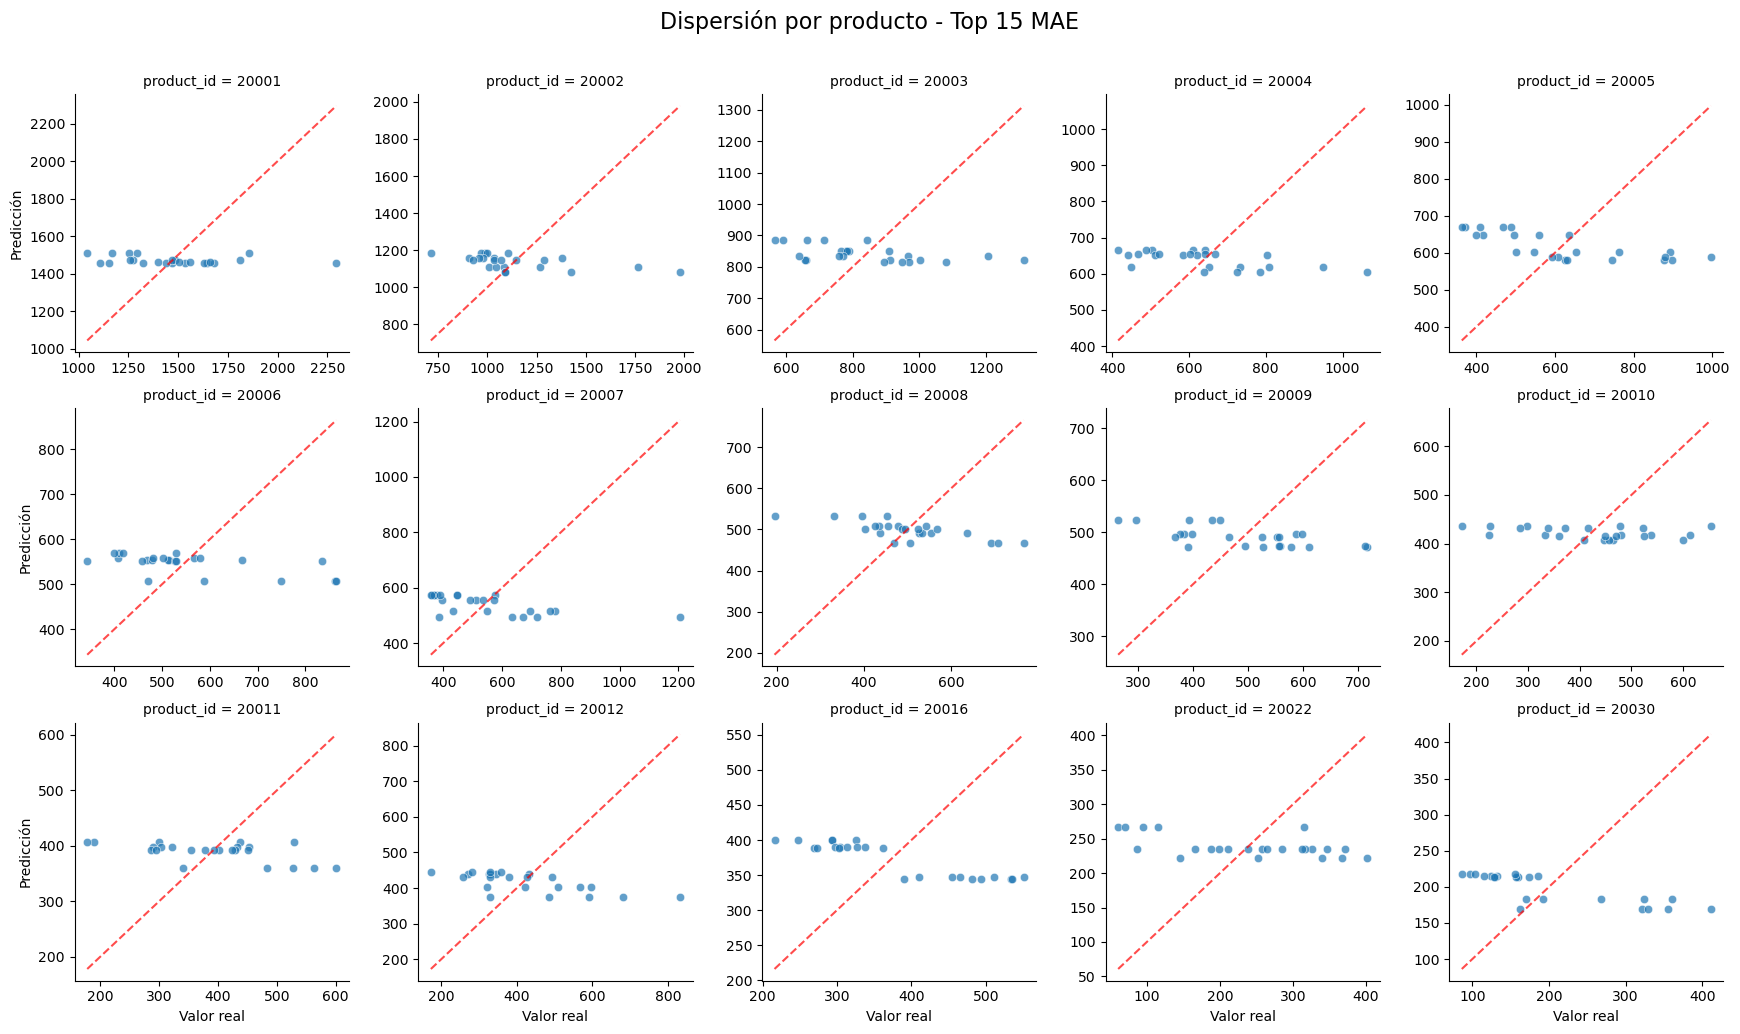

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Cargar archivo generado
df = pd.read_csv("val_real_vs_pred_lgbm_cv2.csv")

# Calcular MAE por producto
df["abs_error"] = abs(df["real"] - df["pred"])
top_mae = df.groupby("product_id")["abs_error"].mean().sort_values(ascending=False).head(15).index
df_top15 = df[df["product_id"].isin(top_mae)]

# Función para agregar línea de identidad
def identidad(data, **kwargs):
    ax = plt.gca()
    lims = [
        min(data["real"].min(), data["pred"].min()),
        max(data["real"].max(), data["pred"].max())
    ]
    ax.plot(lims, lims, 'r--', alpha=0.7)

# Plot
g = sns.FacetGrid(df_top15, col="product_id", col_wrap=5, height=3.5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="real", y="pred", alpha=0.7)
g.map_dataframe(identidad)
g.set_axis_labels("Valor real", "Predicción")
g.fig.suptitle("Dispersión por producto - Top 15 MAE", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show(  )    
plt.savefig("top15_dispersión_lgbm_cv2.png")
plt.close()


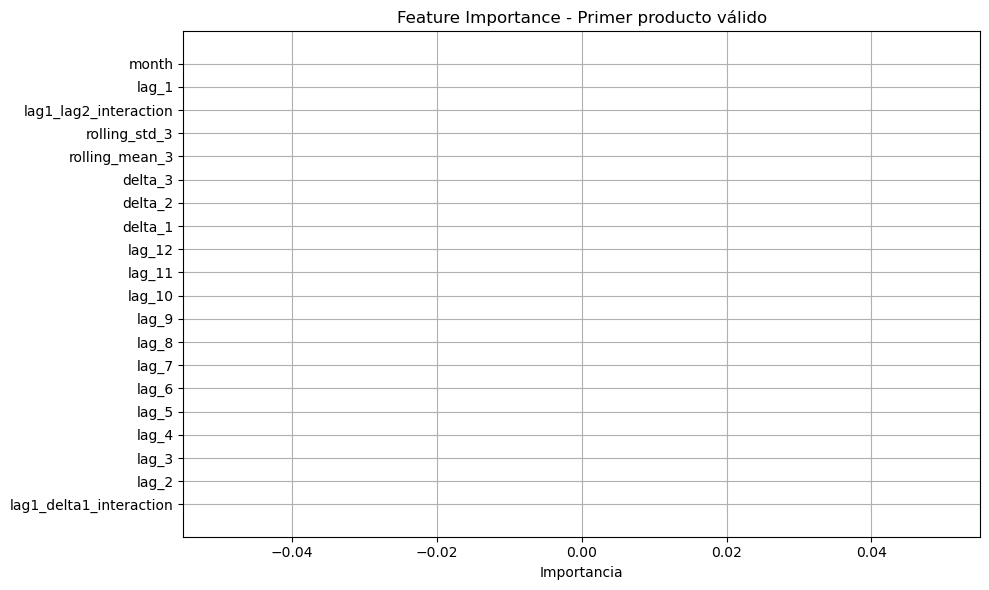

In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar datos
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# 2. Reemplazo de agosto
def reemplazar_agosto(grupo):
    grupo = grupo.copy()
    for i in range(len(grupo)):
        if grupo.iloc[i]["periodo"].month == 8 and i >= 12:
            grupo.iloc[i, grupo.columns.get_loc("tn")] = grupo.iloc[i-12:i]["tn"].mean()
    return grupo

df_corr = df.groupby("product_id").apply(reemplazar_agosto).reset_index(drop=True)

# 3. Features
def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month
    for lag in range(1, 13):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)
    data["delta_1"] = data["lag_1"] - data["lag_2"]
    data["delta_2"] = data["lag_2"] - data["lag_3"]
    data["delta_3"] = data["lag_3"] - data["lag_4"]
    data["rolling_mean_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).mean())
    data["rolling_std_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).std())
    data["lag1_lag2_interaction"] = data["lag_1"] * data["lag_2"]
    data["lag1_delta1_interaction"] = data["lag_1"] * data["delta_1"]
    return data

df_feat = crear_features(df_corr)

# 4. Leer universo
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()

# 5. Entrenar modelo sobre primer producto válido
for prod in productos_objetivo:
    df_prod = df_feat[df_feat["product_id"] == prod].copy()
    train = df_prod[df_prod["periodo"] <= "2019-12-01"].dropna()
    if len(train) >= 15:
        X = train.drop(columns=["product_id", "periodo", "tn"])
        y = train["tn"]
        modelo = lgb.LGBMRegressor(random_state=42)
        modelo.fit(X, y)
        importancia = pd.DataFrame({
            "feature": X.columns,
            "importance": modelo.feature_importances_
        }).sort_values(by="importance", ascending=False)
        break

# 6. Plot de importancias
plt.figure(figsize=(10, 6))
plt.barh(importancia["feature"], importancia["importance"])
plt.xlabel("Importancia")
plt.title("Feature Importance - Primer producto válido")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.savefig("feature_importance_lgbm.png")
plt.show()


In [14]:
print("Shape de X:", X.shape)
print("Varianza por feature:")
print(X.var())

modelo.fit(X, y)
print("Importancias:", modelo.feature_importances_)


Shape de X: (24, 20)
Varianza por feature:
month                      1.243478e+01
lag_1                      8.523263e+04
lag_2                      8.574535e+04
lag_3                      8.529401e+04
lag_4                      8.409598e+04
lag_5                      8.488903e+04
lag_6                      8.836429e+04
lag_7                      8.492227e+04
lag_8                      8.327382e+04
lag_9                      8.547952e+04
lag_10                     8.548216e+04
lag_11                     9.933626e+04
lag_12                     1.068120e+05
delta_1                    1.459926e+05
delta_2                    1.457161e+05
delta_3                    1.457637e+05
rolling_mean_3             3.339295e+04
rolling_std_3              2.002922e+04
lag1_lag2_interaction      4.467133e+11
lag1_delta1_interaction    4.333349e+11
dtype: float64
Importancias: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Producto usado: 20001
Shape de X: (24, 20)
Varianza por feature:
month                      1.243478e+01
lag_1                      8.523263e+04
lag_2                      8.574535e+04
lag_3                      8.529401e+04
lag_4                      8.409598e+04
lag_5                      8.488903e+04
lag_6                      8.836429e+04
lag_7                      8.492227e+04
lag_8                      8.327382e+04
lag_9                      8.547952e+04
lag_10                     8.548216e+04
lag_11                     9.933626e+04
lag_12                     1.068120e+05
delta_1                    1.459926e+05
delta_2                    1.457161e+05
delta_3                    1.457637e+05
rolling_mean_3             3.339295e+04
rolling_std_3              2.002922e+04
lag1_lag2_interaction      4.467133e+11
lag1_delta1_interaction    4.333349e+11
dtype: float64


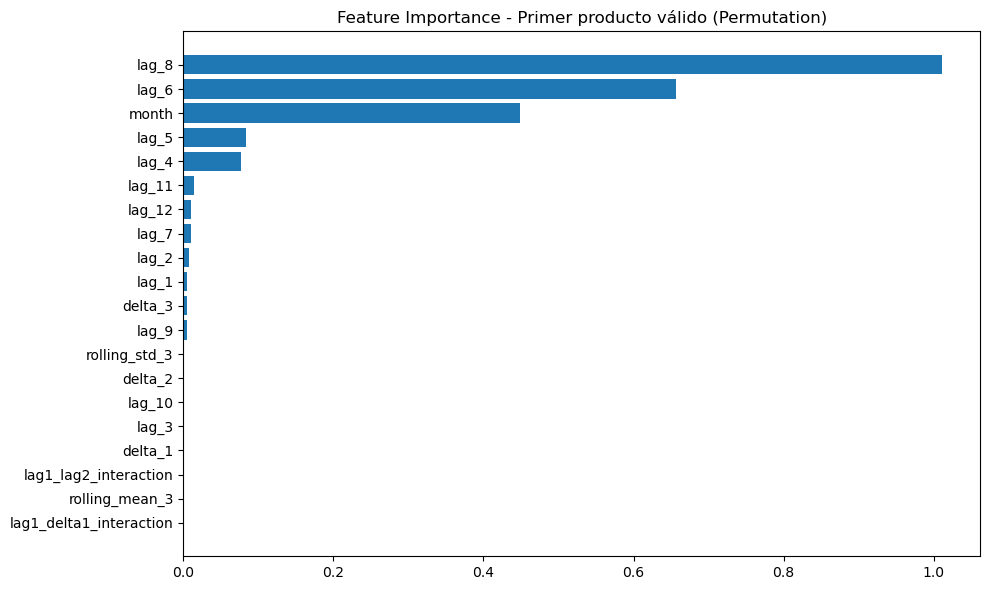

In [15]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar y preparar
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# 2. Reemplazo agosto
def reemplazar_agosto(grupo):
    grupo = grupo.copy()
    for i in range(len(grupo)):
        if grupo.iloc[i]["periodo"].month == 8 and i >= 12:
            grupo.iloc[i, grupo.columns.get_loc("tn")] = grupo.iloc[i-12:i]["tn"].mean()
    return grupo

df_corr = df.groupby("product_id").apply(reemplazar_agosto).reset_index(drop=True)

# 3. Features
def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month
    for lag in range(1, 13):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)
    data["delta_1"] = data["lag_1"] - data["lag_2"]
    data["delta_2"] = data["lag_2"] - data["lag_3"]
    data["delta_3"] = data["lag_3"] - data["lag_4"]
    data["rolling_mean_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).mean())
    data["rolling_std_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).std())
    data["lag1_lag2_interaction"] = data["lag_1"] * data["lag_2"]
    data["lag1_delta1_interaction"] = data["lag_1"] * data["delta_1"]
    return data

df_feat = crear_features(df_corr)

# 4. Leer universo
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()

# 5. Buscar primer producto con suficientes datos
for prod in productos_objetivo:
    data_prod = df_feat[df_feat["product_id"] == prod].copy()
    data_prod = data_prod[data_prod["periodo"] <= "2019-12-01"]
    data_prod = data_prod.dropna()
    
    if data_prod.shape[0] >= 20:
        X = data_prod.drop(columns=["product_id", "periodo", "tn"])
        y = data_prod["tn"]
        print(f"Producto usado: {prod}")
        print(f"Shape de X: {X.shape}")
        print("Varianza por feature:")
        print(X.var())
        break

# 6. Entrenar modelo (parámetros relajados)
modelo = lgb.LGBMRegressor(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    min_data_in_leaf=1,
    min_split_gain=0,
    random_state=42
)
modelo.fit(X, y)

# 7. Permutation importance
importancias = permutation_importance(modelo, X, y, n_repeats=10, random_state=42)
importancia_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importancias.importances_mean
}).sort_values(by="importance", ascending=False)

# 8. Exportar y graficar
importancia_df.to_csv("feature_importance_perm_lgbm.csv", index=False)

plt.figure(figsize=(10, 6))
plt.barh(importancia_df["feature"], importancia_df["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Primer producto válido (Permutation)")
plt.tight_layout()
plt.savefig("feature_importance_perm_lgbm.png")
plt.show()


In [16]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar y preparar datos
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# 2. Leer universo de productos objetivo
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()

# 3. Completar valores faltantes con 0 solo para los productos objetivo
todos_periodos = df["periodo"].sort_values().unique()
panel = pd.MultiIndex.from_product([productos_objetivo, todos_periodos], names=["product_id", "periodo"])
df = df.set_index(["product_id", "periodo"]).reindex(panel, fill_value=0).reset_index()

# 4. Reemplazo de agosto
def reemplazar_agosto(grupo):
    grupo = grupo.copy()
    for i in range(len(grupo)):
        if grupo.iloc[i]["periodo"].month == 8 and i >= 12:
            grupo.iloc[i, grupo.columns.get_loc("tn")] = grupo.iloc[i-12:i]["tn"].mean()
    return grupo

df_corr = df.groupby("product_id").apply(reemplazar_agosto).reset_index(drop=True)

# 5. Features
def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month

    for lag in range(1, 13):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)

    data["delta_1"] = data["lag_1"] - data["lag_2"]
    data["delta_2"] = data["lag_2"] - data["lag_3"]
    data["delta_3"] = data["lag_3"] - data["lag_4"]

    data["rolling_mean_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).mean())
    data["rolling_std_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).std())
    data["rolling_mean_6"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).mean())
    data["rolling_std_6"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).std())

    data["lag_1*lag_2"] = data["lag_1"] * data["lag_2"]
    data["lag_1*delta_1"] = data["lag_1"] * data["delta_1"]
    data["lag_1/lag_2"] = data["lag_1"] / (data["lag_2"] + 1e-6)

    return data

df_feat = crear_features(df_corr)

# 6. Inicializar
resultados = []
maes_lgbm = []
predicciones_validacion = []
entrenados = 0
fallbacks = 0

# 7. Loop por producto
for producto in productos_objetivo:
    data_prod = df_feat[df_feat["product_id"] == producto].copy()
    train = data_prod[data_prod["periodo"] <= "2019-12-01"]

    columnas_lags = [f"lag_{i}" for i in range(1, 13)]
    columnas_adicionales = ["delta_1", "delta_2", "delta_3", "rolling_mean_3", "rolling_std_3",
                            "rolling_mean_6", "rolling_std_6", "lag_1*lag_2", "lag_1*delta_1", "lag_1/lag_2"]

    columnas_features = ["month"] + columnas_lags + columnas_adicionales

    train = train.dropna(subset=columnas_features)

    try:
        if train.shape[0] >= 15:
            X = train[columnas_features]
            y = train["tn"]

            maes = []
            val_preds = []
            for train_idx, val_idx in KFold(n_splits=5, shuffle=False).split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                modelo = lgb.LGBMRegressor(
                    learning_rate=0.1,
                    n_estimators=100,
                    max_depth=6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42
                )
                modelo.fit(X_train, y_train)
                y_pred_val = modelo.predict(X_val)
                maes.append(mean_absolute_error(y_val, y_pred_val))

                val_preds.extend(zip(y_val, y_pred_val))

            mae_cv = np.mean(maes)
            modelo.fit(X, y)

            fila_pred = data_prod.loc[data_prod["periodo"] == "2019-12-01"]
            if not fila_pred.empty and not fila_pred[columnas_features].isnull().any(axis=1).all():
                X_pred = fila_pred[columnas_features].iloc[0:1]
                pred = modelo.predict(X_pred)[0]
                resultados.append({"product_id": producto, "tn_predicho": pred})
                maes_lgbm.append({"product_id": producto, "mae_cv": mae_cv})

                for real, pred_v in val_preds:
                    predicciones_validacion.append({"product_id": producto, "real": real, "pred": pred_v})

                entrenados += 1
                continue

    except Exception as e:
        print(f"\u26a0\ufe0f Fallo producto {producto}: {e}")

    # Fallback
    data_hist = df[(df["product_id"] == producto) & (df["periodo"] < "2020-01-01")]
    ultimos_12 = data_hist.sort_values("periodo").tail(12)
    prom_ultimos12 = ultimos_12["tn"].mean() if not ultimos_12.empty else 0.0
    febreros = data_hist[data_hist["periodo"].dt.month == 2]
    prom_febreros = febreros["tn"].mean() if not febreros.empty else 0.0
    pred = 0.6 * prom_ultimos12 + 0.4 * prom_febreros

    resultados.append({"product_id": producto, "tn_predicho": pred})
    maes_lgbm.append({"product_id": producto, "mae_cv": 9999})
    fallbacks += 1

# 8. Exportar
pd.DataFrame(resultados).to_csv("predicciones_febrero2020_lgbm_agosto_cv3.csv", index=False)
pd.DataFrame(maes_lgbm).to_csv("mae_lgbm_cv3.csv", index=False)
pd.DataFrame(predicciones_validacion).to_csv("val_real_vs_pred_lgbm_cv3.csv", index=False)

print("\n✅ Archivo generado: predicciones_febrero2020_lgbm_agosto_cv3.csv")
print("📄 MAE por producto: mae_lgbm_cv3.csv")
print("📊 Validaciones: val_real_vs_pred_lgbm_cv3.csv")
print(f"✅ Modelos entrenados: {entrenados}")
print(f"❌ Fallbacks aplicados: {fallbacks}")
print(f"🎯 Total productos: {len(productos_objetivo)}")



✅ Archivo generado: predicciones_febrero2020_lgbm_agosto_cv3.csv
📄 MAE por producto: mae_lgbm_cv3.csv
📊 Validaciones: val_real_vs_pred_lgbm_cv3.csv
✅ Modelos entrenados: 780
❌ Fallbacks aplicados: 0
🎯 Total productos: 780


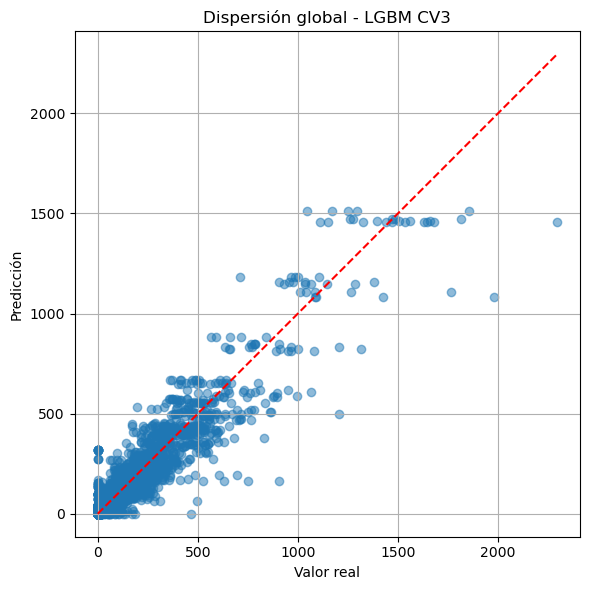

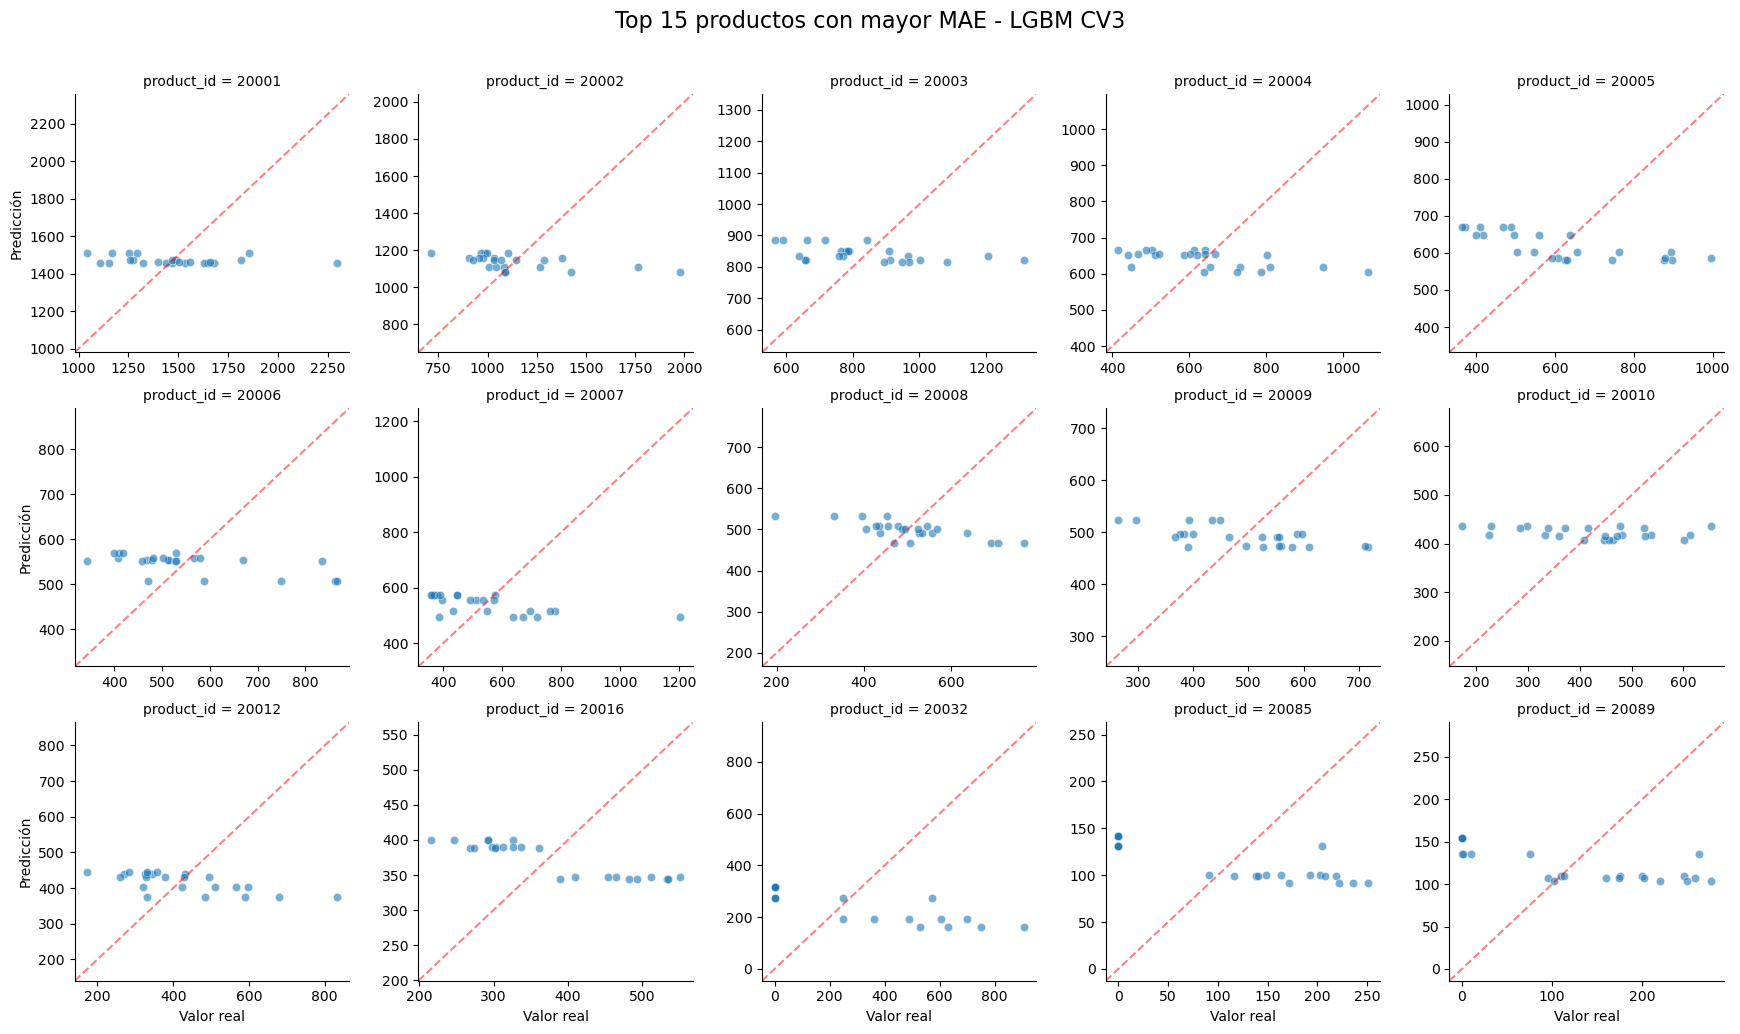

✅ Archivos generados:
- top15_mae_lgbm_cv3.csv
- dispersión_global_lgbm_cv3.png
- top15_mae_scatter_lgbm_cv3.png


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# 1. Cargar archivo de validación real vs. predicción
val_real_pred = pd.read_csv("val_real_vs_pred_lgbm_cv3.csv")

# 2. Calcular MAE por producto
mae_por_producto = val_real_pred.groupby("product_id").apply(
    lambda x: mean_absolute_error(x["real"], x["pred"])
).reset_index(name="mae")

# 3. Top 15 productos con mayor MAE
top15 = mae_por_producto.sort_values("mae", ascending=False).head(15)
top15.to_csv("top15_mae_lgbm_cv3.csv", index=False)

# 4. Gráfico global de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(val_real_pred["real"], val_real_pred["pred"], alpha=0.5)
plt.plot(
    [val_real_pred["real"].min(), val_real_pred["real"].max()],
    [val_real_pred["real"].min(), val_real_pred["real"].max()],
    "r--"
)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Dispersión global - LGBM CV3")
plt.grid(True)
plt.tight_layout()
plt.savefig("dispersión_global_lgbm_cv3.png")
plt.show()
plt.close()

# 5. Gráficos por producto (top 15)
df_top15 = val_real_pred[val_real_pred["product_id"].isin(top15["product_id"])]
g = sns.FacetGrid(df_top15, col="product_id", col_wrap=5, height=3.5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="real", y="pred", alpha=0.6)
for ax in g.axes.flatten():
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, "r--", alpha=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

g.set_axis_labels("Valor real", "Predicción")
g.fig.suptitle("Top 15 productos con mayor MAE - LGBM CV3", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig("top15_mae_scatter_lgbm_cv3.png")
plt.show()
plt.close()

print("✅ Archivos generados:")
print("- top15_mae_lgbm_cv3.csv")
print("- dispersión_global_lgbm_cv3.png")
print("- top15_mae_scatter_lgbm_cv3.png")


In [25]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar y preparar datos
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# 2. Leer universo de productos objetivo
productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()

# 3. Completar valores faltantes con 0 solo para los productos objetivo
todos_periodos = df["periodo"].sort_values().unique()
panel = pd.MultiIndex.from_product([productos_objetivo, todos_periodos], names=["product_id", "periodo"])
df = df.set_index(["product_id", "periodo"]).reindex(panel, fill_value=0).reset_index()

# 4. Reemplazo de agosto
def reemplazar_agosto(grupo):
    grupo = grupo.copy()
    for i in range(len(grupo)):
        if grupo.iloc[i]["periodo"].month == 8 and i >= 12:
            grupo.iloc[i, grupo.columns.get_loc("tn")] = grupo.iloc[i-12:i]["tn"].mean()
    return grupo

df_corr = df.groupby("product_id").apply(reemplazar_agosto).reset_index(drop=True)

# 5. Features
def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month

    for lag in range(1, 13):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)

    data["delta_1"] = data["lag_1"] - data["lag_2"]
    data["delta_2"] = data["lag_2"] - data["lag_3"]
    data["delta_3"] = data["lag_3"] - data["lag_4"]

    data["rolling_mean_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).mean())
    data["rolling_std_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).std())
    data["rolling_mean_6"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).mean())
    data["rolling_std_6"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).std())

    data["lag_1*lag_2"] = data["lag_1"] * data["lag_2"]
    data["lag_1*delta_1"] = data["lag_1"] * data["delta_1"]
    data["lag_1/lag_2"] = data["lag_1"] / (data["lag_2"] + 1e-6)

    return data

df_feat = crear_features(df_corr)

# 6. Inicializar
resultados = []
maes_lgbm = []
predicciones_validacion = []
entrenados = 0
fallbacks = 0

# Bellacos
bellacos = {20001, 20006, 20007,  20012, 20017, 20032, 20018, 20043.20033}

# 7. Loop por producto
for producto in productos_objetivo:
    if producto in bellacos:
        data_hist = df[(df["product_id"] == producto) & (df["periodo"] < "2020-01-01")].sort_values("periodo")
        ult_3 = data_hist.tail(3)["tn"].mean()
        ult_6 = data_hist.tail(6)["tn"].mean()
        ult_12 = data_hist.tail(12)["tn"].mean()
        febreros = data_hist[data_hist["periodo"].dt.month == 2]["tn"].mean()
        pred = np.mean([ult_3, ult_6, ult_12, febreros])

        resultados.append({"product_id": producto, "tn_predicho": pred})
        maes_lgbm.append({"product_id": producto, "mae_cv": 8888})
        continue

    data_prod = df_feat[df_feat["product_id"] == producto].copy()
    train = data_prod[data_prod["periodo"] <= "2019-12-01"]

    columnas_lags = [f"lag_{i}" for i in range(1, 13)]
    columnas_adicionales = ["delta_1", "delta_2", "delta_3", "rolling_mean_3", "rolling_std_3",
                            "rolling_mean_6", "rolling_std_6", "lag_1*lag_2", "lag_1*delta_1", "lag_1/lag_2"]

    columnas_features = ["month"] + columnas_lags + columnas_adicionales

    train = train.dropna(subset=columnas_features)

    try:
        if train.shape[0] >= 15:
            X = train[columnas_features]
            y = train["tn"]

            maes = []
            val_preds = []
            for train_idx, val_idx in KFold(n_splits=5, shuffle=False).split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                modelo = lgb.LGBMRegressor(
                    learning_rate=0.1,
                    n_estimators=100,
                    max_depth=6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42
                )
                modelo.fit(X_train, y_train)
                y_pred_val = modelo.predict(X_val)
                maes.append(mean_absolute_error(y_val, y_pred_val))

                val_preds.extend(zip(y_val, y_pred_val))

            mae_cv = np.mean(maes)
            modelo.fit(X, y)

            fila_pred = data_prod.loc[data_prod["periodo"] == "2019-12-01"]
            if not fila_pred.empty and not fila_pred[columnas_features].isnull().any(axis=1).all():
                X_pred = fila_pred[columnas_features].iloc[0:1]
                pred = modelo.predict(X_pred)[0]
                resultados.append({"product_id": producto, "tn_predicho": pred})
                maes_lgbm.append({"product_id": producto, "mae_cv": mae_cv})

                for real, pred_v in val_preds:
                    predicciones_validacion.append({"product_id": producto, "real": real, "pred": pred_v})

                entrenados += 1
                continue

    except Exception as e:
        print(f"⚠️ Fallo producto {producto}: {e}")

    # Fallback
    data_hist = df[(df["product_id"] == producto) & (df["periodo"] < "2020-01-01")]
    ultimos_12 = data_hist.sort_values("periodo").tail(12)
    prom_ultimos12 = ultimos_12["tn"].mean() if not ultimos_12.empty else 0.0
    febreros = data_hist[data_hist["periodo"].dt.month == 2]
    prom_febreros = febreros["tn"].mean() if not febreros.empty else 0.0
    pred = 0.6 * prom_ultimos12 + 0.4 * prom_febreros

    resultados.append({"product_id": producto, "tn_predicho": pred})
    maes_lgbm.append({"product_id": producto, "mae_cv": 9999})
    fallbacks += 1

# 8. Exportar
pd.DataFrame(resultados).to_csv("predicciones_febrero2020_lgbm_agosto_cv5.csv", index=False)
pd.DataFrame(maes_lgbm).to_csv("mae_lgbm_cv5.csv", index=False)
pd.DataFrame(predicciones_validacion).to_csv("val_real_vs_pred_lgbm_cv5.csv", index=False)

print("\n✅ Archivo generado: predicciones_febrero2020_lgbm_agosto_cv5.csv")
print("📄 MAE por producto: mae_lgbm_cv5.csv")
print("📊 Validaciones: val_real_vs_pred_lgbm_cv5.csv")
print(f"✅ Modelos entrenados: {entrenados}")
print(f"❌ Fallbacks aplicados: {fallbacks}")
print(f"🎯 Total productos: {len(productos_objetivo)}")



✅ Archivo generado: predicciones_febrero2020_lgbm_agosto_cv5.csv
📄 MAE por producto: mae_lgbm_cv5.csv
📊 Validaciones: val_real_vs_pred_lgbm_cv5.csv
✅ Modelos entrenados: 773
❌ Fallbacks aplicados: 0
🎯 Total productos: 780


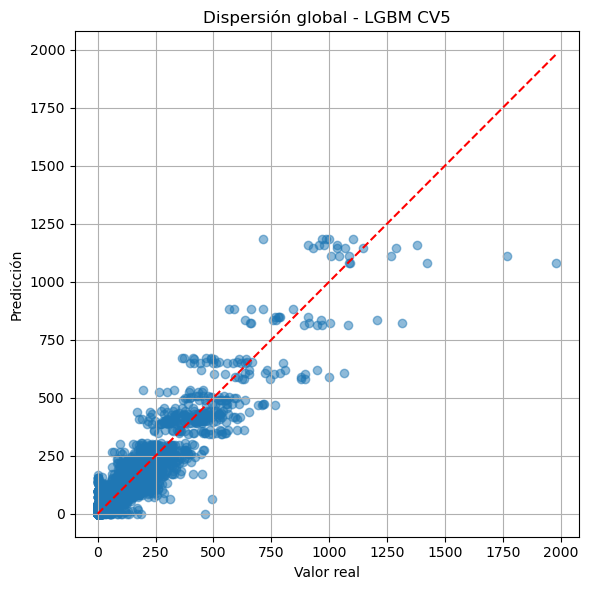

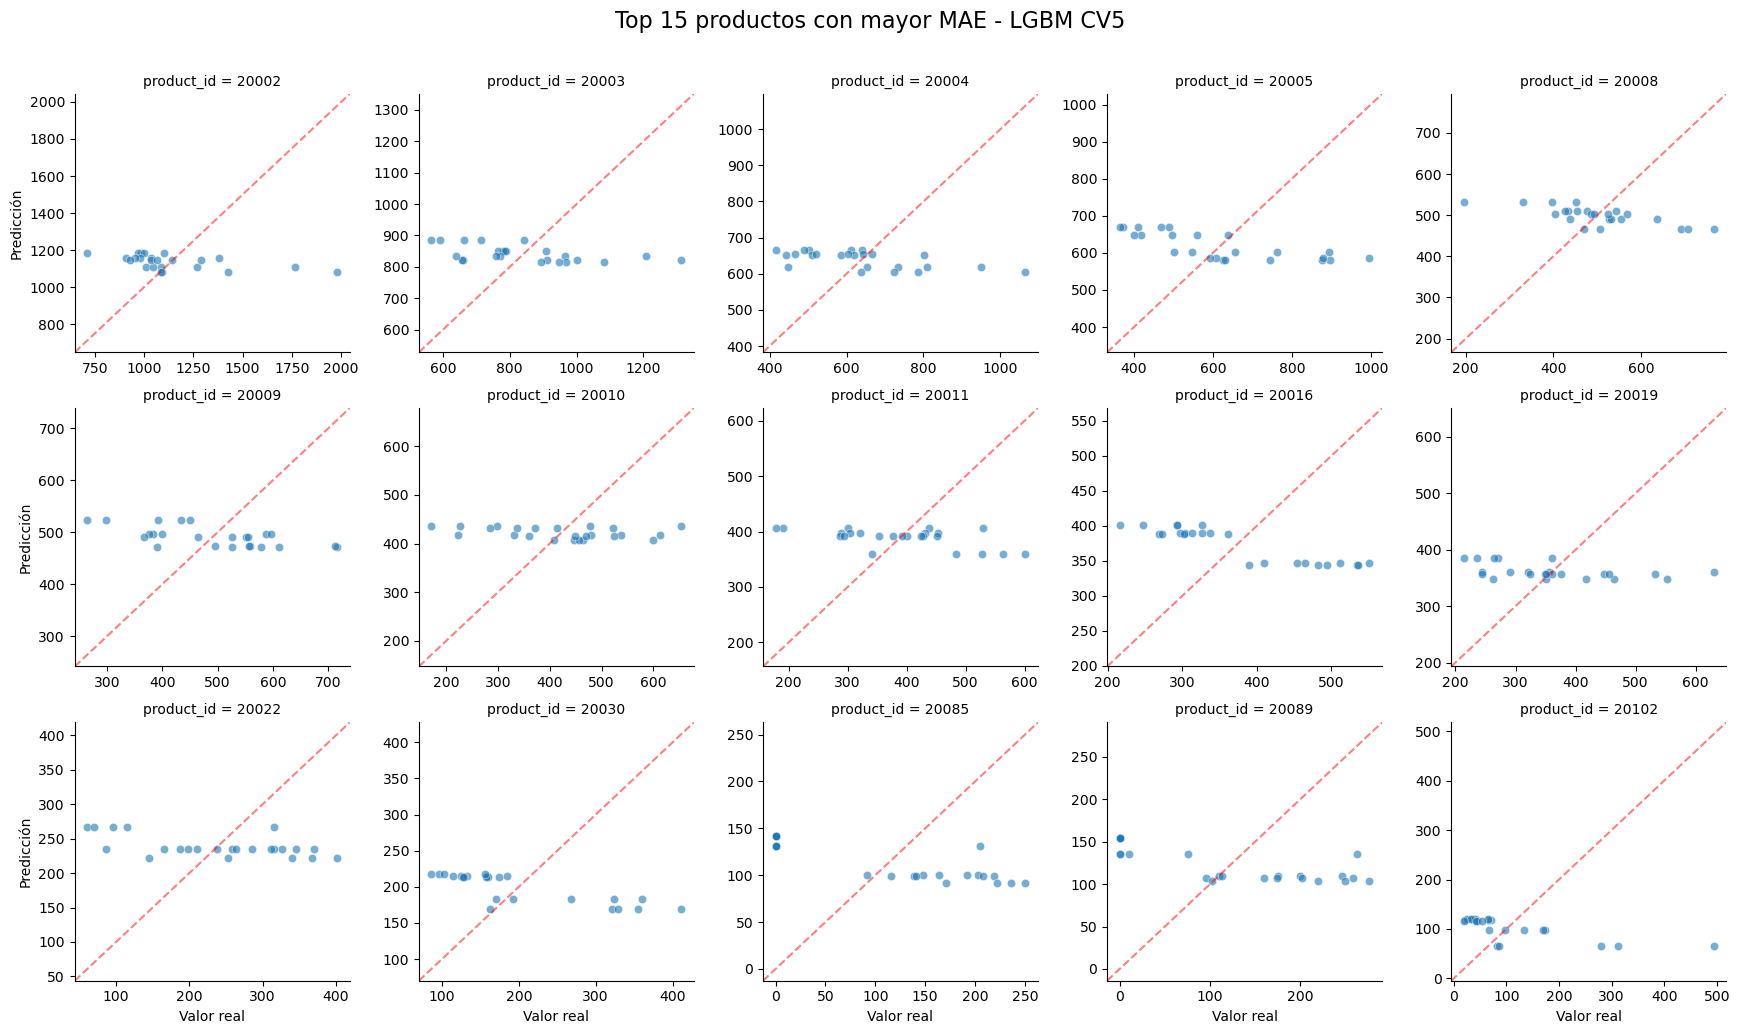

✅ Archivos generados:
- top15_mae_lgbm_cv5.csv
- dispersión_global_lgbm_cv5.png
- top15_mae_scatter_lgbm_cv5.png


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# 1. Cargar archivo de validación real vs. predicción
val_real_pred = pd.read_csv("val_real_vs_pred_lgbm_cv5.csv")

# 2. Calcular MAE por producto
mae_por_producto = val_real_pred.groupby("product_id").apply(
    lambda x: mean_absolute_error(x["real"], x["pred"])
).reset_index(name="mae")

# 3. Top 15 productos con mayor MAE
top15 = mae_por_producto.sort_values("mae", ascending=False).head(15)
top15.to_csv("top15_mae_lgbm_cv5.csv", index=False)

# 4. Gráfico global de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(val_real_pred["real"], val_real_pred["pred"], alpha=0.5)
plt.plot(
    [val_real_pred["real"].min(), val_real_pred["real"].max()],
    [val_real_pred["real"].min(), val_real_pred["real"].max()],
    "r--"
)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Dispersión global - LGBM CV5")
plt.grid(True)
plt.tight_layout()
plt.savefig("dispersión_global_lgbm_cv5.png")
plt.show()
plt.close()

# 5. Gráficos por producto (top 15)
df_top15 = val_real_pred[val_real_pred["product_id"].isin(top15["product_id"])]
g = sns.FacetGrid(df_top15, col="product_id", col_wrap=5, height=3.5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="real", y="pred", alpha=0.6)
for ax in g.axes.flatten():
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, "r--", alpha=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

g.set_axis_labels("Valor real", "Predicción")
g.fig.suptitle("Top 15 productos con mayor MAE - LGBM CV5", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig("top15_mae_scatter_lgbm_cv5.png")
plt.show()
plt.close()

print("✅ Archivos generados:")
print("- top15_mae_lgbm_cv5.csv")
print("- dispersión_global_lgbm_cv5.png")
print("- top15_mae_scatter_lgbm_cv5.png")


In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar datos
df = pd.read_csv("sell-in.txt", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df = df.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

productos_objetivo = pd.read_csv("product_id_apredecir201912.txt")["product_id"].tolist()
todos_periodos = df["periodo"].sort_values().unique()
panel = pd.MultiIndex.from_product([productos_objetivo, todos_periodos], names=["product_id", "periodo"])
df = df.set_index(["product_id", "periodo"]).reindex(panel, fill_value=0).reset_index()

# 2. Reemplazo de agosto con promedio de últimos 12 meses
def reemplazar_agosto(grupo):
    grupo = grupo.copy()
    for i in range(len(grupo)):
        if grupo.iloc[i]["periodo"].month == 8 and i >= 12:
            grupo.iloc[i, grupo.columns.get_loc("tn")] = grupo.iloc[i-12:i]["tn"].mean()
    return grupo

df_corr = df.groupby("product_id").apply(reemplazar_agosto).reset_index(drop=True)

# 3. Generar features
def crear_features(data):
    data = data.copy()
    data["month"] = data["periodo"].dt.month
    data["year"] = data["periodo"].dt.year

    for lag in range(1, 13):
        data[f"lag_{lag}"] = data.groupby("product_id")["tn"].shift(lag)

    data["delta_1"] = data["lag_1"] - data["lag_2"]
    data["delta_2"] = data["lag_2"] - data["lag_3"]
    data["delta_3"] = data["lag_3"] - data["lag_4"]

    data["rolling_mean_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).mean())
    data["rolling_std_3"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).std())
    data["rolling_mean_6"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).mean())
    data["rolling_std_6"] = data.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).std())

    data["lag_1*lag_2"] = data["lag_1"] * data["lag_2"]
    data["lag_1*delta_1"] = data["lag_1"] * data["delta_1"]
    data["lag_1/lag_2"] = data["lag_1"] / (data["lag_2"] + 1e-6)

    # Estadísticas adicionales
    data["mean_2019"] = data.apply(lambda row: row["tn"] if row["year"] == 2019 else np.nan, axis=1)
    data["mean_2019"] = data.groupby("product_id")["mean_2019"].transform(lambda x: x.shift(1).rolling(12).mean())

    data["feb_2019"] = np.where((data["month"] == 2) & (data["year"] == 2019), data["tn"], np.nan)
    data["feb_2018"] = np.where((data["month"] == 2) & (data["year"] == 2018), data["tn"], np.nan)
    data["feb_2019"] = data.groupby("product_id")["feb_2019"].transform("max")
    data["feb_2018"] = data.groupby("product_id")["feb_2018"].transform("max")
    data["feb_ratio"] = data["feb_2019"] / (data["feb_2018"] + 1e-6)

    return data

df_feat = crear_features(df_corr)

# 4. Entrenamiento por producto
resultados, maes_lgbm, predicciones_validacion = [], [], []
entrenados, fallbacks = 0, 0

columnas_lags = [f"lag_{i}" for i in range(1, 13)]
columnas_adicionales = [
    "delta_1", "delta_2", "delta_3", "rolling_mean_3", "rolling_std_3",
    "rolling_mean_6", "rolling_std_6", "lag_1*lag_2", "lag_1*delta_1", "lag_1/lag_2",
    "mean_2019", "feb_ratio"
]
columnas_features = ["month"] + columnas_lags + columnas_adicionales

for producto in productos_objetivo:
    try:
        data_prod = df_feat[df_feat["product_id"] == producto].copy()
        train = data_prod[data_prod["periodo"] <= "2019-12-01"]

        # Eliminar columnas que tengan más de 50% de NaN
        cols_validas = [col for col in columnas_features if train[col].isna().mean() < 0.5]
        train = train.dropna(subset=cols_validas)

        if len(train) < 10:
            raise ValueError("No hay suficientes datos para entrenar")

        X = train[cols_validas]
        y = train["tn"]
        maes = []
        val_preds = []

        for train_idx, val_idx in KFold(n_splits=5).split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = np.log1p(y.iloc[train_idx]), np.log1p(y.iloc[val_idx])

            modelo = lgb.LGBMRegressor(
                learning_rate=0.1,
                n_estimators=100,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            )
            modelo.fit(X_train, y_train, sample_weight=np.sqrt(np.expm1(y_train)))
            y_pred_val = np.expm1(modelo.predict(X_val))
            y_val_real = np.expm1(y_val)

            maes.append(mean_absolute_error(y_val_real, y_pred_val))
            val_preds.extend(zip(y_val_real, y_pred_val))

        modelo.fit(X, np.log1p(y), sample_weight=np.sqrt(y))
        fila_pred = data_prod[data_prod["periodo"] == "2019-12-01"]

        if not fila_pred.empty:
            X_pred = fila_pred[cols_validas].iloc[0:1].fillna(0)
            pred = np.expm1(modelo.predict(X_pred)[0])
        else:
            raise ValueError("Fila de predicción vacía")

        resultados.append({"product_id": producto, "tn_predicho": pred})
        maes_lgbm.append({"product_id": producto, "mae_cv": np.mean(maes)})

        for real, pred_v in val_preds:
            predicciones_validacion.append({"product_id": producto, "real": real, "pred": pred_v})

        entrenados += 1

    except Exception as e:
        data_hist = df[(df["product_id"] == producto) & (df["periodo"] < "2020-01-01")]
        ultimos_12 = data_hist.sort_values("periodo").tail(12)
        prom_ultimos12 = ultimos_12["tn"].mean() if not ultimos_12.empty else 0.0
        febreros = data_hist[data_hist["periodo"].dt.month == 2]
        prom_febreros = febreros["tn"].mean() if not febreros.empty else 0.0
        pred = 0.6 * prom_ultimos12 + 0.4 * prom_febreros

        resultados.append({"product_id": producto, "tn_predicho": pred})
        maes_lgbm.append({"product_id": producto, "mae_cv": 9999})
        predicciones_validacion.append({"product_id": producto, "real": np.nan, "pred": pred})
        fallbacks += 1
        print(f"⚠️ Fallback producto {producto}: {str(e)}")

# 5. Exportar resultados
pd.DataFrame(resultados).to_csv("predicciones_febrero2020_lgbm_cv5_blindado.csv", index=False)
pd.DataFrame(maes_lgbm).to_csv("mae_lgbm_cv5_blindado.csv", index=False)
pd.DataFrame(predicciones_validacion).to_csv("val_real_vs_pred_lgbm_cv5_blindado.csv", index=False)

print("\n✅ Archivo generado: predicciones_febrero2020_lgbm_cv5_blindado.csv")
print("📄 MAE por producto: mae_lgbm_cv5_blindado.csv")
print("📊 Validaciones: val_real_vs_pred_lgbm_cv5_blindado.csv")
print(f"✅ Modelos entrenados: {entrenados}")
print(f"❌ Fallbacks aplicados: {fallbacks}")
print(f"🎯 Total productos: {len(productos_objetivo)}")



✅ Archivo generado: predicciones_febrero2020_lgbm_cv5_blindado.csv
📄 MAE por producto: mae_lgbm_cv5_blindado.csv
📊 Validaciones: val_real_vs_pred_lgbm_cv5_blindado.csv
✅ Modelos entrenados: 780
❌ Fallbacks aplicados: 0
🎯 Total productos: 780


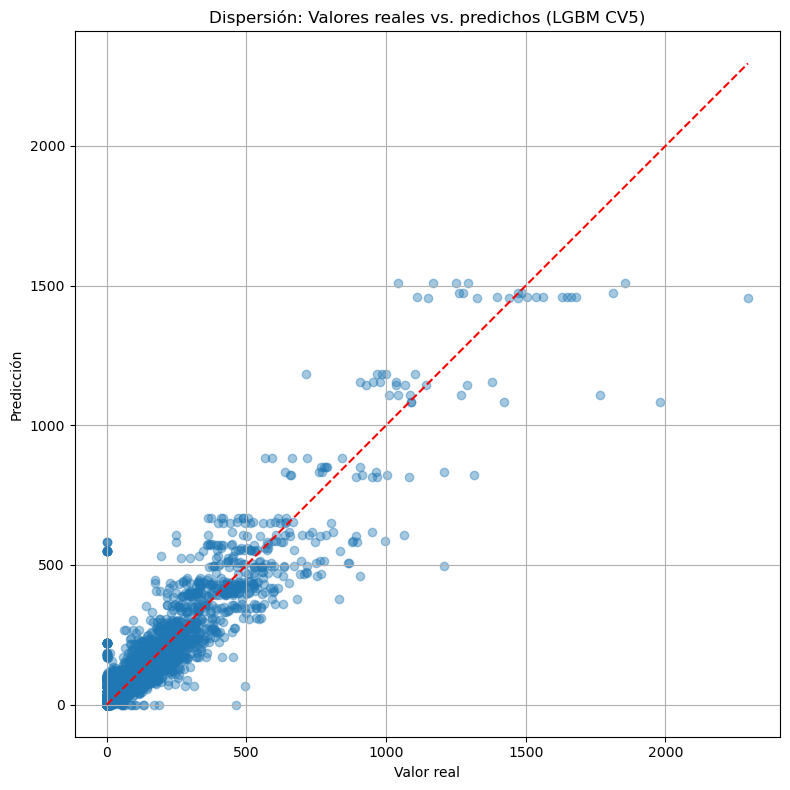

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos de validación cruzada (no los de predicción final)
df = pd.read_csv("val_real_vs_pred_lgbm_cv5_blindado.csv")

plt.figure(figsize=(8, 8))
plt.scatter(df["real"], df["pred"], alpha=0.4)
plt.plot([0, max(df["real"].max(), df["pred"].max())],
         [0, max(df["real"].max(), df["pred"].max())],
         'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Dispersión: Valores reales vs. predichos (LGBM CV5)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

df = pd.read_csv("val_real_vs_pred_lgbm_cv5_blindado.csv")
print(df.shape)
print(df.head(25))


(18720, 3)
    product_id         real         pred
0        20001  1169.075320  1510.928355
1        20001  1043.764700  1510.928355
2        20001  1856.835340  1510.928355
3        20001  1251.284620  1510.928355
4        20001  1293.897880  1510.928355
5        20001  1150.791690  1455.149879
6        20001  1470.410090  1455.149879
7        20001  1324.168212  1455.149879
8        20001  1438.674550  1455.149879
9        20001  2295.198320  1455.149879
10       20001  1813.015110  1474.609771
11       20001  1486.686690  1474.609771
12       20001  1275.773510  1474.609771
13       20001  1259.093630  1474.609771
14       20001  1470.656530  1474.609771
15       20001  1647.638480  1458.853349
16       20001  1629.782330  1458.853349
17       20001  1109.937690  1458.853349
18       20001  1678.993180  1458.853349
19       20001  1535.801519  1458.853349
20       20001  1660.005610  1459.889402
21       20001  1561.505520  1459.889402
22       20001  1397.372310  1459.889402
23   

In [4]:
import pandas as pd
import plotly.express as px

# Cargar archivo de validación cruzada
df = pd.read_csv("val_real_vs_pred_lgbm_cv5_blindado.csv")

# Filtrar puntos válidos (sin fallback)
df = df.dropna(subset=["real"])

# Crear gráfico interactivo
fig = px.scatter(
    df,
    x="real",
    y="pred",
    hover_data=["product_id"],
    title="Dispersión real vs. predicho (solo modelos entrenados)",
    labels={"real": "Valor real", "pred": "Predicción"}
)

# Línea identidad
fig.add_shape(
    type="line",
    x0=0, y0=0,
    x1=df["real"].max(), y1=df["real"].max(),
    line=dict(color="red", dash="dash"),
    name="Ideal"
)

fig.update_layout(width=700, height=700)
fig.show()
